# Regression Coefficients Nullspace Perspective
This notebook contains contains edamples and visualizations of the nullspace perspective for regression in high dimensions. 
Corresponding paper: 

Contact: Joachim Schaeffer, joachim.schaeffer@posteo.de

In [1]:
import sys
import os

abspath = r"./src/"
sys.path.append(os.path.abspath(abspath ))

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(42)
np.random.seed(42)

# Custom functions
from hd_data import HD_Data
from basis_function_data import PolynomBasis, construct_data, construct_y_data
from nullspace import Nullspace

from utils import optimise_pls_cv
from plotting_utils import plot_X

%load_ext autoreload
%autoreload 2

In [2]:
# Varibles to set. 
# Paths are OS dependent.

# Data path
data_path = './data/'

# If outlier should be removed.
remove_outlier = False

# Shall plots be saved?
save_plots = True

# Path to save plots
if remove_outlier:
    save_plot_path = './results/NullspaceNoOutlier/' 
else:
    save_plot_path = './results/Nullspace/'
    # save_plot_path = './../Nullspace/Figures/' 

plt.style.use('./src/plots.mplstyle')

# Plot additional visualizations.
extra_plots = 0

# Load data that was used for the publication
# Is set to true, the data for the plots will be loaded from csv files. 
# If set to false the data will be generated and figures might differ slightly due to the random structure of the noise.
load_data = True

# If load data=False and save_data=True, the csv files will be replaced with the data genearated during this run.
save_data = False


In [3]:
# Create PLS Model objects. 
# You can also used RR or lasso or other models instead.

model_PLS1 = PLSRegression(n_components=1, tol=1e-7, scale=False)
model_PLS2 = PLSRegression(n_components=2, tol=1e-7, scale=False)
model_PLS3 = PLSRegression(n_components=3, tol=1e-7, scale=False)
model_PLS4 = PLSRegression(n_components=4, tol=1e-7, scale=False)
model_PLS5 = PLSRegression(n_components=5, tol=1e-7, scale=False)
model_PLS6 = PLSRegression(n_components=6, tol=1e-7, scale=False)

models = [model_PLS1, model_PLS2, model_PLS3, model_PLS4, model_PLS5, model_PLS6]
model_names = ['PLS 1 Comp.', 'PLS 2 Comp.', 'PLS 3 Comp.', 'PLS 4 Comp.', 'PLS 5 Comp.', 'PLS 6 Comp.']

### Example I: Parabolas

In [4]:
if not load_data:
    d_min = 1.0
    d_max = 3.0
    means = np.array([0, 0, 0.3])
    stdv = np.array([0, 0, 0.3])
    n = 50
    p = 201
    d = np.linspace(d_min, d_max, p)[:, None]

    # True feature is the mean
    mean_function = lambda a : np.mean(a)

    # Data without noise
    poly_basis = PolynomBasis(len(means), [d_min, d_max], center=0)
    poly_data = construct_data(poly_basis, mean_function, means, stdv, num_datapoints=p, draws=n, plot_results=1)
    poly_hd_data = HD_Data(X=poly_data.X, d=d, y=poly_data.y)
    # Data with noise
    snr = 50
    poly_hd_data_n = HD_Data(X=poly_data.X.copy(), d=d.copy(), y=poly_data.y.copy()).add_wgn(snr_x=snr, snr_y=snr)

    if save_data: 
        np.savetxt(
            data_path + "poly_hd_data.csv", np.hstack((poly_hd_data.X, np.expand_dims(poly_hd_data.y, axis=1))), delimiter=",", 
            header=f"Col. 0-49 X, col 50: x, col 51: y, poly. basis params.: means = {means}, stdv = {stdv}, y col. {n}, sample mean, no noise \n d = {d.T}")
        np.savetxt(
            data_path + "poly_hd_data_n.csv", np.hstack((poly_hd_data_n.X, np.expand_dims(poly_hd_data_n.y, axis=1))), delimiter=",", 
            header=f"Col. 0-49 X, col 50: x, col 51: y, poly. basis params.: means = {means}, stdv = {stdv}, y col. {n}, sample mean, added noise, snr = {snr} \n d = {d.T}")
else: 
    temp = np.loadtxt(data_path + "poly_hd_data.csv", skiprows=1, delimiter=",") 
    temp_n = np.loadtxt(data_path + "poly_hd_data_n.csv", skiprows=1, delimiter=",") 
    # Parameters from header ofcsv file
    d = np.linspace(1.0, 3.0, temp[:,:-1].shape[1])[:, None]

    poly_hd_data = HD_Data(X=temp[:,:-1], d=d, y=temp[:,-1]) 
    poly_hd_data_n = HD_Data(X=temp_n[:,:-1], d=d, y=temp_n[:,-1]) 

mean_reg_coef = (1/poly_hd_data.X.shape[1]) * np.ones(poly_hd_data.X.shape[1])

Constraint value: 0.000000000000, Method NRMSE


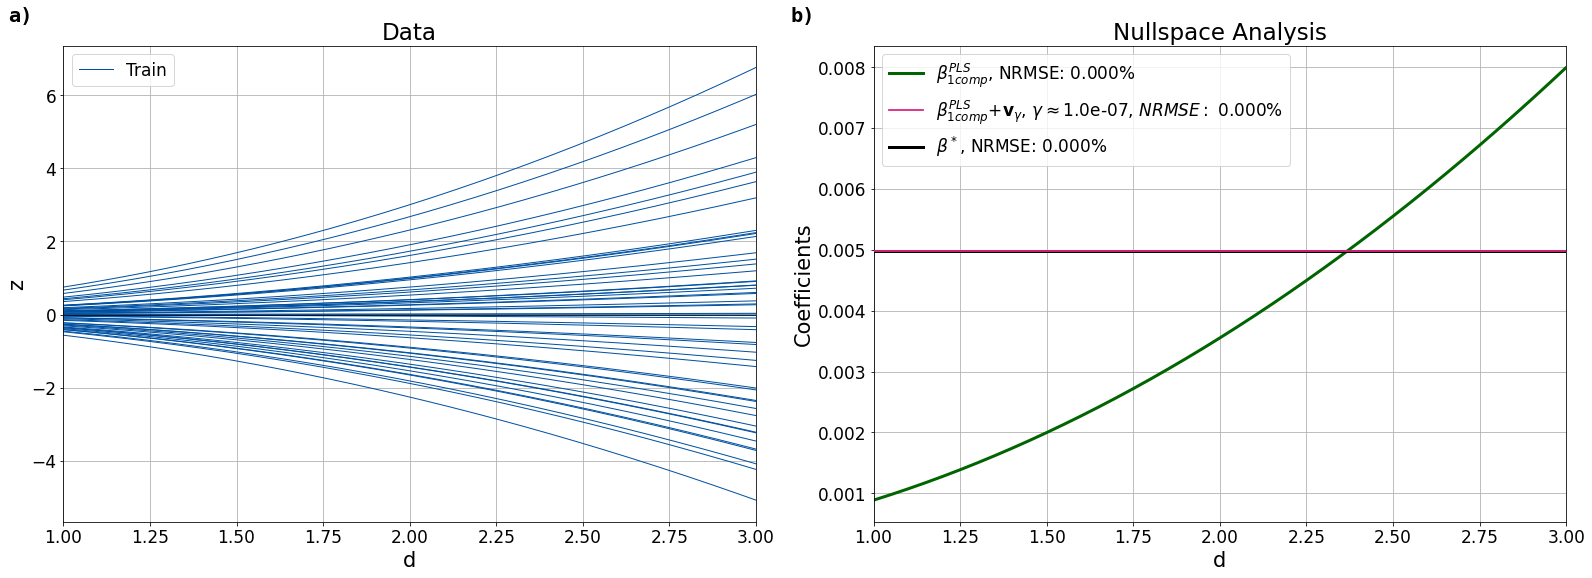

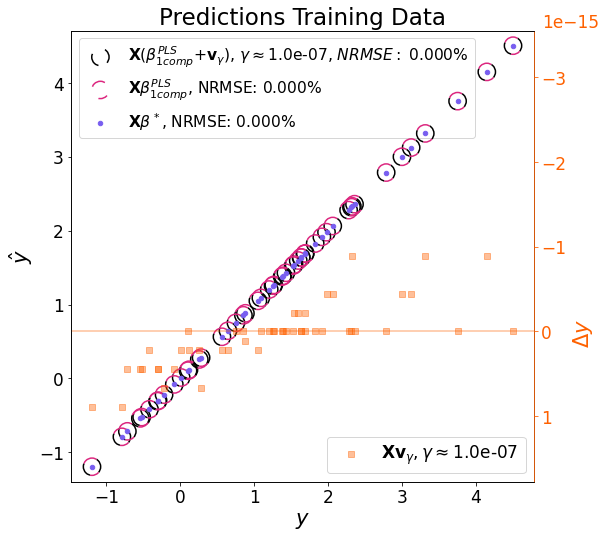

In [5]:
nulls_parab = Nullspace(poly_hd_data)
nulls_parab = nulls_parab.learn_weights([model_PLS1], ['PLS 1 Comp.'])
nulls_parab.set_standardization(std=False)
file_name='Polynomial_example.pdf'

nulls_parab.set_nullspace_weights(
    key_alpha = 'PLS 1 Comp.', 
    w_alpha_name=r'$\beta_{1 comp}^{PLS}$',
    w_beta = mean_reg_coef, 
    w_beta_name=r'$\beta^*$'
    )

nulls_parab, fig, ax = nulls_parab.nullspace_analysis(
    nullspace_path = False, 
    plot_results=True, 
    save_plot=save_plots, 
    path_save=save_plot_path, 
    file_name=file_name, 
    opt_gamma_method='NRMSE', 
    con_thres=10**(-13),
    )  

kwargs_scatter = {
    "y_coords" : [1.08, 0.33], 
    "ax_labelstr" : "", 
    "save_plot" : save_plots, 
    "path_save" : save_plot_path,
    "file_name" : file_name,
    }
nulls_parab.scatter_predictions(title="Predictions Training Data", **kwargs_scatter)

Constraint value: 0.000661250076


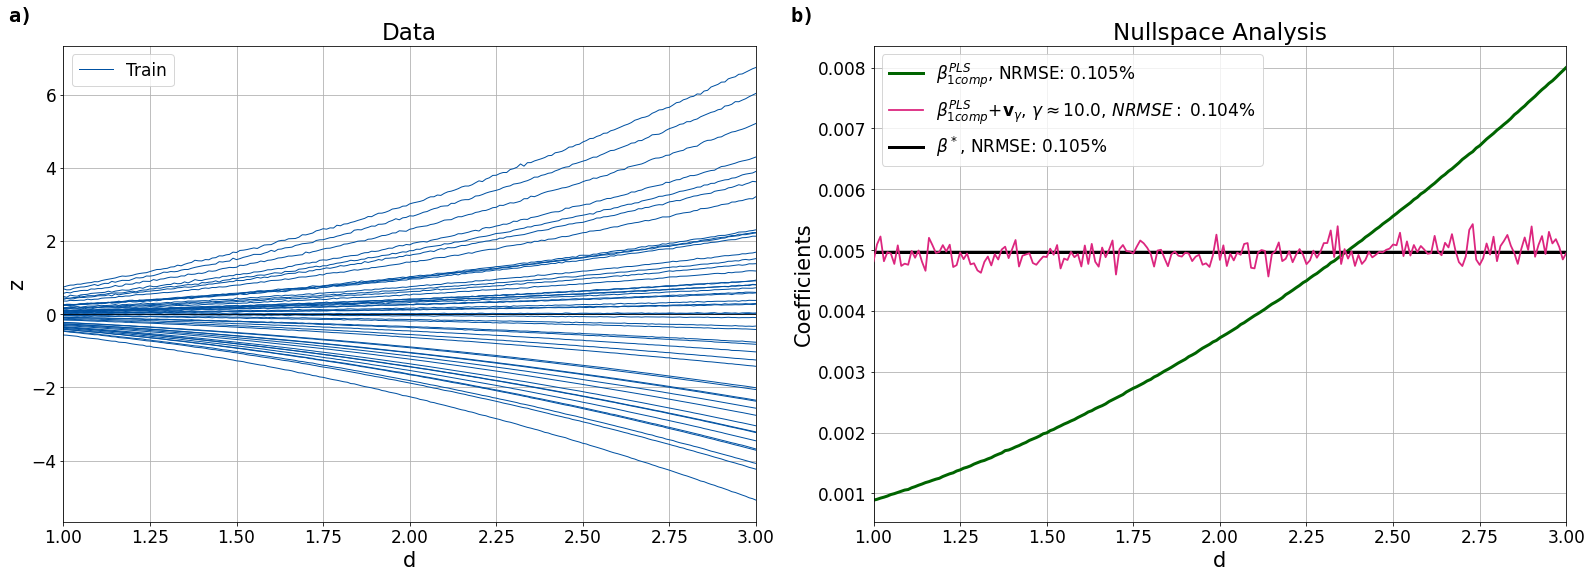

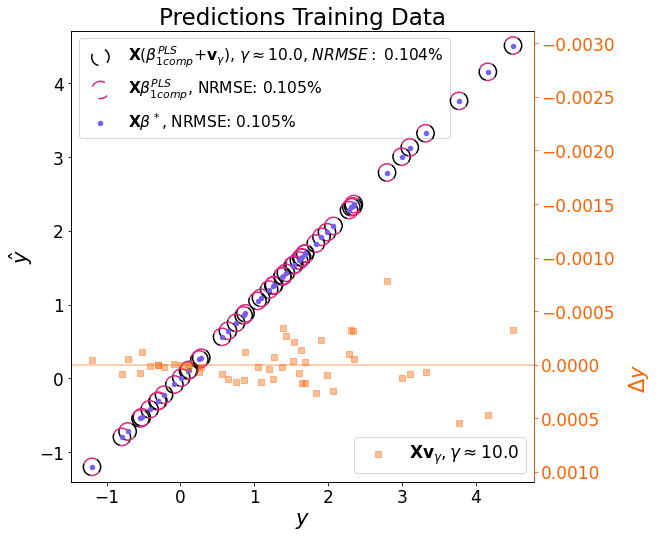

In [6]:
nulls_parab_n = Nullspace(poly_hd_data_n)
nulls_parab_n = nulls_parab_n.learn_weights([model_PLS1], ['PLS 1 Comp.'])
nulls_parab_n.set_standardization(std=False)
file_name='Polynomial_example_noise.pdf'

nulls_parab_n.set_nullspace_weights(
    key_alpha = 'PLS 1 Comp.', 
    w_alpha_name=r'$\beta_{1 comp}^{PLS}$',
    w_beta = mean_reg_coef, 
    w_beta_name=r'$\beta^*$'
    )
    
nulls_parab_n, fig, ax = nulls_parab_n.nullspace_analysis(
    nullspace_path = False,
    plot_results=True, 
    save_plot=save_plots, 
    path_save=save_plot_path, 
    file_name=file_name, 
    opt_gamma_method='NRMSE', 
    ax_labelstr = ("a)", "b)"),
    gamma_vals = [10],
    )

kwargs_scatter = {
    "y_coords" : [1.2, 0.23],
    "ax_labelstr" : "", 
    "save_plot" : save_plots, 
    "path_save" : save_plot_path,
    "file_name" : file_name,
    }

nulls_parab_n.scatter_predictions(title="Predictions Training Data", **kwargs_scatter)

In [7]:
# Loading regression coefficients obtained in R with glmnet (ridge regression) and genlasso (fused lasso)
file_name = "regression_in_R/parab_n_reg_coeff.csv"
reg_coef_df = pd.read_csv(file_name)
nulls_rr_fl = Nullspace(poly_hd_data_n)
nulls_rr_fl.set_standardization(std=False)
nulls_rr_fl.set_nullspace_weights(
        w_alpha = reg_coef_df.coef_1se_cv_rr,
        w_alpha_name = r"$\beta_{CV 1SE}^{RR}$",
        w_beta = reg_coef_df.coef_1se_cv_fused_lasso,
        w_beta_name = r"$\beta_{CV 1SE}^{FL}$")

Constraint value: 0.000818094280


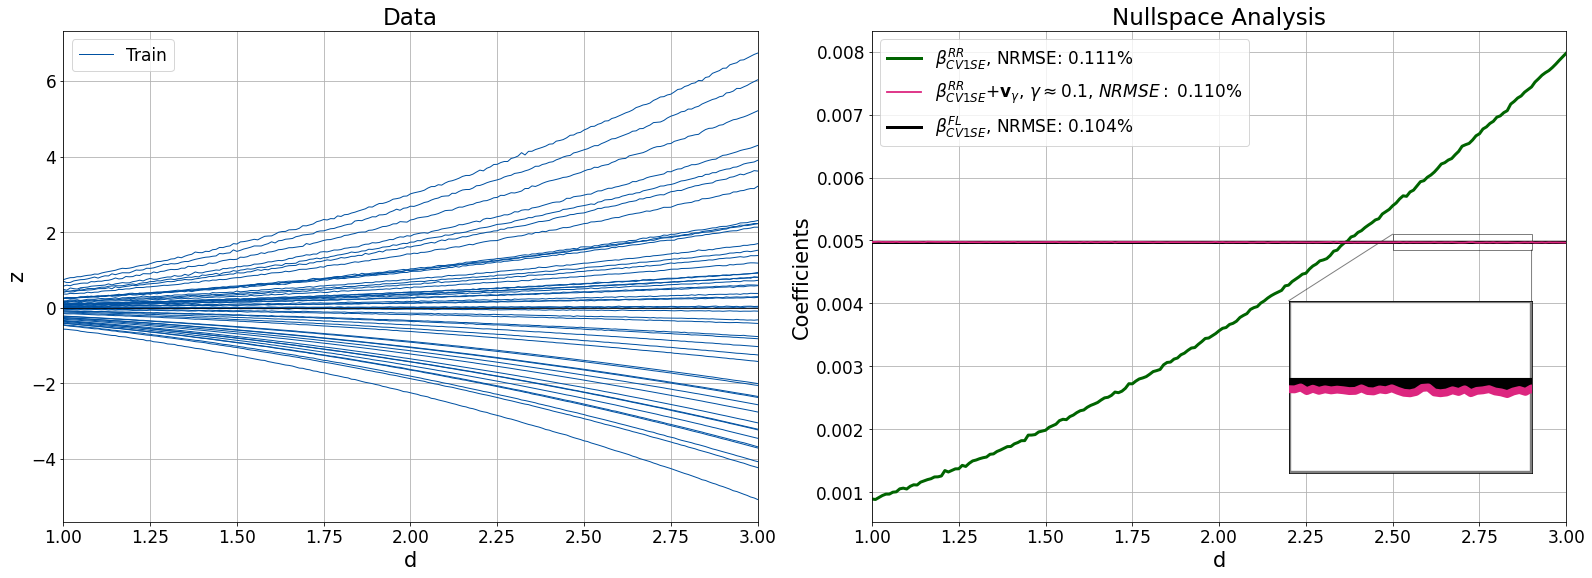

In [8]:
file_name='Polynomial_example_fl_rr.pdf'
nulls_rr_fl, fig, ax = nulls_rr_fl.nullspace_analysis(
    analyse_objective_trajectory = False,
    nullspace_path = False,
    plot_results=True, 
    save_plot=save_plots, 
    path_save=save_plot_path, 
    file_name=file_name, 
    opt_gamma_method='NRMSE', 
    ax_labelstr = ("", ""),
    # con_thres = -0.15,
    gamma_vals = [0.1],
    inset_axes_ce = [0.6, 0.1, 0.35, 0.35],
    zoom_coords = [2.5, 2.9, 0.00485, 0.0051],
    )

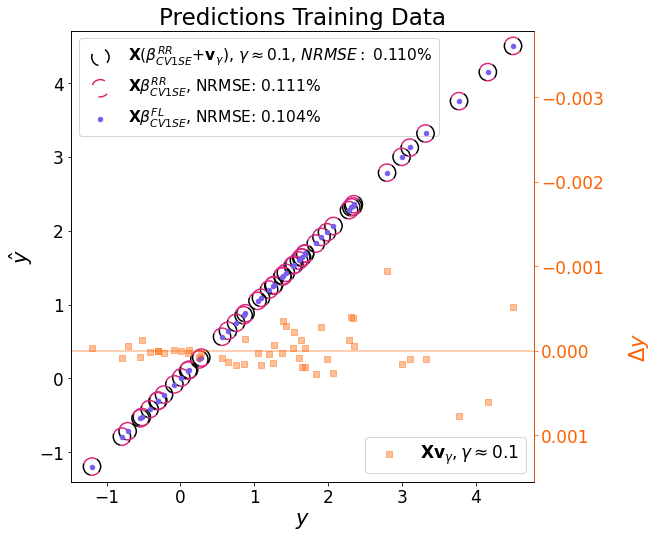

In [9]:
kwargs_scatter = {
    "y_coords" : [1.2, 0.3],
    "ax_labelstr" : "", 
    "save_plot" : save_plots, 
    "path_save" : save_plot_path,
    "file_name" : file_name,
    }

nulls_rr_fl.scatter_predictions(title="Predictions Training Data", **kwargs_scatter)